## Predicting the Success of Cyber-Related Terrorist Attacks:

This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

It is a rich dataset with numerous variables and plenty of opportunities for analysis.  In this project, we will focus on predicting the 'success' of attacks which are related to cyber-events or have consequences for cyber-infrastructure (we will describe these characteristics in further detail below.   

To begin, we will take a look at how this study classifies a successful terrorist attack and distinguishes it from an unsuccessful attack.  Below, is their description from pages 11 and 26 of their code-book (__[GTD Global Terrorism Database. Codebook: Inclusion Criteria and Variables](http://www.start.umd.edu/gtd/downloads/Codebook.pdf)__):

> "The GTD does not include plots or conspiracies that are not enacted, or at least attempted. For
an event to be included in the GTD, the attackers must be “out the door,” en route to execute
the attack. Planning, reconnaissance, and acquiring supplies do not meet this threshold.
The GTD does include attacks that were attempted but ultimately unsuccessful. The
circumstances vary depending on tactics (for details see the success variable, below). However,
in general if a bomb is planted but fails to detonate; if an arsonist is intercepted by authorities
before igniting a fire; or, if an assassin attempts and fails to kill his or her intended target, the
attack is considered for inclusion in the GTD, and marked success=0." P. 11

> "Success of a terrorist strike is defined according to the tangible effects of the attack.
Success is not judged in terms of the larger goals of the perpetrators. For example, a
bomb that exploded in a building would be counted as a success even if it did not
succeed in bringing the building down or inducing government repression.
The definition of a successful attack depends on the type of attack. Essentially, the
key question is whether or not the attack type took place. If a case has multiple
attack types, it is successful if any of the attack types are successful, with the
exception of assassinations, which are only successful if the intended target is killed.
        1 = "Yes" The incident was successful.
        0 = "No" The incident was not successful." P. 26

Thus, our focus below will be on using the data collected to build a model which will successfully predict the success of a terror attack.  Below, we will begin importing and working with our data, and explanations and analysis will follow when pertinent.

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [3]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [4]:
# Renaming our columns for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

#### B. Selecting Rows Specific to Cyber-Related Terrorism:

> In order to filter the dataset and focus our inquiry on cyber-related events, we will use the following regex statement.  This statement attempts to focus on social-networks, email platforms as well as infrastructure (to a certain extent).

> It should be note that this statement is susceptible to bias in a few ways.  First of all, it is temporally biased in the sense that it includes Facebook and Twitter, while newer platforms or platforms in other countries might be prevalent. One way to reduce this bias would be to update the expression whenever possible with current data and considerations of standard practice and user habits.

In [5]:
# Creating the input Dataframe (cyber_train):
# Using regex to isolate qualifying data and make a mask to filter our main dataframe:

import re

  # First taking a look to see how many rows that will give us to work with:
    
print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating the mask:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Filtering our main data:

cyber_data = pd.DataFrame(cyber_data[mask])

False    172205
True       9486
Name: summary, dtype: int64


#### C. Splitting Our Train/Test Data:

> Below, we dropped some specific columns in dataframe in order to make future processing more efficient.  The 'event_id' column wasn't numerically significant and created problems when getting dummies was necessary. The same occured with 'summary' and 'motive.'  These last two columns, however, will come in handy when considering avenues for further research, which we will discuss below.

In [6]:
from sklearn.model_selection import cross_val_score, train_test_split

In [7]:
# Defining our Input and Output data:
# (Cleaning afterwards to prevent leakage)

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25)

X_train_start_index = X_train.index
X_test_start_index = X_test.index

#### D. Isolating Columns:

> We want to be sure we are only using the numeric columns that are significant (i.e. binary or numerically related to the values they contain) and not arbitrary categoricals (such as using numbers to classify one instance over another):

In [8]:
cyber_train_X = X_train[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure input and output dataframes still have the same amount of rows:

cyber_train_Y = Y_train.iloc[Y_train.index == cyber_train_X.index]

In [9]:
# Applying the same process above to our test data:

cyber_test_X = X_test[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

cyber_test_Y = Y_test.iloc[Y_test.index == cyber_test_X.index]

#### E. Applying Filters to Text Columns.

The cells below are an attempt to consolidate (or group) some of the values together with a few certain columns we will be focusing on.  Given that these columns have a considerable number of unique values, when getting dummies later, it will greatly increase the size of our feature set.  While an increased feature-set is not necessarily a bad thing, preventing the size from becoming too large will aid in our explanatory power later on.  In other words, our feature set will have a comprehensible size, allowing us to explain the characteristics around a successful attack. Otherwise, we run the risk of a feature set which is too large for a human to understand and too many features - making it difficult to see which columns/characteristics are significant for our analysis.

Below, we focus mainly on the types of weapons, the named terrorist groups and the cities attacked.  We also consolidated some of the sub_targets into larger groups.  After running our preliminary models, we found that targets and sub_targets were significant to our models, so we conducted some further feature engineering afterwards, which we will discuss later.

There were a number of resources which were helpful in this grouping process, which we will lay out here:

> Regarding the 'weapontxt' column, which describes the type of weapons used in the attack, and the 'sub_target' column (which provides further details on the primary target) we mainly referred to the codebook accompanying the study (as mentioned above: (__[GTD Global Terrorism Database. Codebook: Inclusion Criteria and Variables](http://www.start.umd.edu/gtd/downloads/Codebook.pdf)__)).  The grouping below was rather simple - primarily placing a few types of weapon-groups and sub-targets together when it would not negatively impact our explanatory capabilites down the road.

> The 'city' and 'group_name' columns were more technical and involved some outside research.  The groupings below are aimed at linking cities together if they fall within an ideological, religious, environmental or political umbrella in which certain terrorist groups are interested.  For example, some middle-eastern cities are considered to lean more 'Sunni' as opposed to 'Shia', while others are 'split.'  Some South American cities lie within an area experiencing heavy gang activity (such as the Northern Triangle between Mexico and Panama).  Our goal with these groupings was to combine cities whenever they had a common interest factor for terrorist events, in the hopes that it would consolidate their correlation and aid in our predictive models.  

> These groupings, however, can be improved upon with further in-depth research.  Our time with this project was somewhat limited and there are a handful of regions we were unable to group together or research.  Additionally, our expertise in global terrorism is slight in comparison to those working in the field, which would benefit from an expert team member when creating these filters.  That said, it would be highly interesting to continue improving these classifications, especially given the wealth of information and databases made available by respected international research organizations, which we will list here:

> Some cities and groups were classified according to their religious leanings:
>> - Some Middle-Eastern cities were grouped under a Sunni/Shia or Sunni/Shia Split category.  These resources were helpful in ascertaining where a city fell with respect to these religious tendencies:
>>> -  A New York Times article by Sarah Almukhtar, Sergio Peçanha and Tim Wallace on January 5th, 2016, entitled: __[Behind Stark Political Divisions, a More
Complex Map of Sunnis and Shiites.](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__
>>> - A blog post by Olivier Ypsilantis on August 14th, 2014, entitled: __[Carte religieuse de l’Iran et ses voisins](http://zakhor-online.com/?attachment_id=7932)__.
>>> - Max Fisher wrote a great article for Vox on March 26th, 2015 which has a lot of great maps for reference: __[40 maps that explain the Middle East](https://www.vox.com/a/maps-explain-the-middle-east)__
>>> The Gulf 2000 Project has a plethora of maps and resources regarding issues in the Middle-East, and specifically this page by Dr. Michael Izady entitled __[Atlas of the Islamic World and Vicinity
(Infographs, Maps and Statistics Collection).](http://gulf2000.columbia.edu/maps.shtml)__ Some other maps we used from this site were: - __[A map of West Africa](http://gulf2000.columbia.edu/images/maps/West_Africa_Religion_lg.png)__
 - __[A map of Libya](http://gulf2000.columbia.edu/images/maps/Libya_Religion_Western_Sector_lg.png)__
 - __[A Shia territories map](http://gulf2000.columbia.edu/images/maps/ShiasReligionCore_lg.png)__

>>> The Crisis Group also has a number of useful resources and articles regarding these topics.  Specifically regarding Colombia and South America, we referenced and article entitled __[Colombia’s Armed Groups Battle for the Spoils of Peace](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace)__ from Report  63 / Latin America & Caribbean 19 OCTOBER 2017.  There was an interesting map by Mike Shand (International Crisis Group 2017), entitled __[Map of Armed Groups and Coca Crops in Colombia, 2017.](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8)__.

> We'll also take this opportunity to list out further databases and resources we used for this project:
>> For 'group_names' we referenced START's resources again (as they have a wealth of resources surrounding the database we used and the elements it describes.  Here, they list the names of __['Big, Allied and Dangerous' terrorist groups,](http://www.start.umd.edu/baad/database)___ which we used as the basis for a majority of our classification.

>> The __[SATP website](http://www.satp.org/conflict-maps/bangladesh)__ was instrumental in gaining insight into Asian conflicts. Within this website, we referenced a specific article regarding the 
__[Nepalise Maoist conflicts](http://www.satp.org/terrorist-profile/nepal/communist-party-of-nepal-maoist)__, which described their objectives, operating areas, leaders, etc.  Towards the bottom of the page, it includes a ranking by the Nepalese Home Ministry, of areas in Nepal according to their sensitivity to these issues.  We then used this __[map](https://reliefweb.int/map/nepal/nepal-regions-zones-and-districts-cities-april-2015)__ from ReliefWeb to help us locate smaller cities in pertinent areas.

> South America and the Northern Triangle:
>> Again, there are a number of databases and materials available from top-level international organizations.  Regarding the Northern Triangle (namely Guatemala, Honduras, El Salvador) we referenced the following articles:
 - __[Central America’s Violent Northern Triangle](https://www.cfr.org/backgrounder/central-americas-violent-northern-triangle)__By Rocio Cara Labrador and Danielle Renwick (updated June 26th, 2018) 
 - The Insight Crime Organiztion has a main page for each country involved in frequent conflicts__[such as this one regarding El Salvador](https://www.insightcrime.org/el-salvador-organized-crime-news/)__   
 - Relief Web also had a variety of resources we used here, specifically a __[main search page](https://reliefweb.int/country/slv)__ for each country that leads to reports, infographics and the like.
 - The __[Humanitarian Reponse Group](https://www.humanitarianresponse.info/en/infographics)__ also has great resources and infographics.
 - The __[United Nations Regional Information Centre](https://www.unric.org/en/databases/26912-refugees-humanitarian-affairs-and-migration)__ points to a number of outside resources depending on what one is looking for.
 - In refrencing hotspots of violence in Guatemala, we used Relief Web's summary on __[Humanitarian Needs Overview for Guatemala in 2017](https://reliefweb.int/sites/reliefweb.int/files/resources/20180315_SUMMARY_HNO%20GT_ENG.pdf)__
 - Regarding the same of El Salvador, we used Relief Web's __[Map of El Salvador.](https://reliefweb.int/sites/reliefweb.int/files/resources/20180405%20monthly%20humanitarian%20snapshot%20-%20ENG.pdf)__
 - For Honduras we referred to an article entitled __['Northern Triangle is World's Extortion Hotspot'](https://www.insightcrime.org/news/brief/northern-triangle-world-extortion-hotspot/)__ by Steven Dudley and Michael Lohmuller on JULY 1st, 2015.  This article has a map that was helpful in locating our cities.
 - Regarding Columbia, we frequently referred to the __[Crisis Group's resources.](https://www.crisisgroup.org/)__ 
There were two articles in particular we referred to here.  The first was entitled 'Colombia’s Armed Groups Battle for the Spoils of Peace' (which we already referenced above).  The second was a map entitled __['Map of ELN Presence in Colombia in 2012 and 2018, and Expansion between 2012 and 2018'](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/68-missing-peace-colombias-new-government-and-last-guerrillas#map-6189-1)__ within an article named __['The Missing Peace: Colombia’s New Government and Last Guerrillas'](https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/68-missing-peace-colombias-new-government-and-last-guerrillas)__ from their Report 68 / Latin America & Caribbean on July 12th, 2018.

>> Other General References include:
 - __[Homeland Security Digital Library](https://www.hsdl.org/?collection&id=2167)__
 - __[U Mass Lowell](https://www.uml.edu/Research/CTSS/Online-Resources.aspx)__ Has a great page with links to further resources.
 - The Council on Foreign Relations has a page entitled __[Invisible Armies Insurgency Tracker: A Visual History of Guerrilla Warfare From 1775 to 2012 (from April 18th, 2013](https://www.cfr.org/wars-and-warfare/invisible-armies-insurgency-tracker/p29917)__.  As they describe it at the top of the page: "The interactive Invisible Armies Insurgency Tracker presents a database of insurgencies from 1775 to 2012. It supplements the comprehensive historical narrative in Invisible Armies: An Epic History of Guerrilla Warfare from Ancient Times to the Present, by CFR Senior Fellow Max Boot."
 - West Point has __[The Combating Terrorism Center](https://ctc.usma.edu/regions/middle-east/)__ which is incredibly helpful and insightful with their background information.
 - __[The Terrorism Research and Analysis Consortium](https://www.trackingterrorism.org/region/afghanistan)__ has a lot of information - mostly private and paid, but one can at least browse the surface of what they offer (we also used some of their 'vulnerable cities' classifications in our cells below).


##### Weapontxt:

> ###### Training Input:

In [10]:
# Grouping Biological and Chemical Weapons:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_train_X['weapontxt'] = cyber_train_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


> ###### Test Input:

In [11]:
# Grouping Biological and Chemical Weapons:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_test_X['weapontxt'] = cyber_test_X['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


##### Sub_targettxt:

> ###### Training Input:

In [12]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_train_X['sub_targettxt'] = cyber_train_X['sub_targettxt'].where(
                                     cyber_train_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

> ###### Test Data:

In [13]:
# Test Data:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'test/test Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_test_X['sub_targettxt'] = cyber_test_X['sub_targettxt'].where(
                                     cyber_test_X['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

##### Group_name:

> Trying Group_name a bit and grouping them by Ideaology.

> ###### Training Input:

In [14]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [15]:
# Asian Separatists:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [16]:
# Middle Eastern Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [17]:
# Indian Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [18]:
# NW_Indian_Groups:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lashkar-e-Jhangvi',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Sipah-e-Sahaba/Pakistan (SSP)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Mujahideen (HM)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Front (BLF)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Baloch Army (UBA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Free Balochistan Army (FBA)',
                                                        'NW_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Baloch Nationalists',
                                                        'NW_Indian_Groups')

In [19]:
# SE_Indian_Groups:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Communist Party of India - Maoist (CPI-Maoist)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Indian Mujahideen',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jama\'atul Mujahideen Bangladesh (JMB)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Bangladesh Sarbahara Party',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Purbo Banglar Communist Party',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Harkatul Jihad-e-Islami',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hynniewtrep National Liberation Council (HNLC)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kanglei Yawol Kanna Lup (KYKL)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kuki Tribal Militants',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Kuki National Front (KNF)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Kuki Liberation Front (UKLF) - India',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hill Tiger Force (HTF)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Khaplang (NSCN-K)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Socialist Council of Nagaland-Unification (NSCN-U)',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('',
                                                        'SE_Indian_Groups')

In [20]:
# African Political:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [21]:
# Irish Separatists
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [22]:
# Farc left and right
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [23]:
# Middle Eastern Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [24]:
# Israeli, Palestinian, Lebanese Religious:
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [25]:
# Asian and African Religious:

cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_train_X['group_name'] = cyber_train_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


> ###### Test Input:

In [26]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [27]:
# Asian Separatists:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [28]:
# Middle Eastern Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [29]:
# Indian Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [30]:
# NW_Indian_Groups:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lashkar-e-Jhangvi',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Sipah-e-Sahaba/Pakistan (SSP)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Mujahideen (HM)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Front (BLF)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Young Tigers (BYT)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Baloch Army (UBA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Free Balochistan Army (FBA)',
                                                        'NW_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Baloch Nationalists',
                                                        'NW_Indian_Groups')

In [31]:
# SE_Indian_Groups:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Communist Party of India - Maoist (CPI-Maoist)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Indian Mujahideen',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jama\'atul Mujahideen Bangladesh (JMB)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Bangladesh Sarbahara Party',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Purbo Banglar Communist Party',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Harkatul Jihad-e-Islami',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hynniewtrep National Liberation Council (HNLC)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kanglei Yawol Kanna Lup (KYKL)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kuki Tribal Militants',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Kuki National Front (KNF)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Kuki Liberation Front (UKLF) - India',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hill Tiger Force (HTF)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Khaplang (NSCN-K)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'SE_Indian_Groups')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Socialist Council of Nagaland-Unification (NSCN-U)',
                                                        'SE_Indian_Groups')

In [32]:
# African Political:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [33]:
# Irish Separatists
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Irish Republican Army (IRA)',
                                                        'Irish_Separatists')


In [34]:
# Farc left and right
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [35]:
# Middle Eastern Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [36]:
# Israeli, Palestinian, Lebanese Religious:
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [37]:
# Asian and African Religious:

cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_test_X['group_name'] = cyber_test_X['group_name'].replace('Boko Haram',
                                                        'African_Religious')


##### City:

> Trying City Names by Religion, Tribal Associations or Conflict Areas:

> ###### Training Input:

In [38]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [39]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [40]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [41]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [42]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [43]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [44]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [45]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [46]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


In [47]:
# Nepal Maoist Conflict - Class A According to SATP
Nepal_maoist_A = ['Musikot', 'Rukumkot', 'Jajarkot District', 'Salyan', 'Pyuthan', 'Gajul', 'Rank', 'Budagaun',
                  'Kalikot District', 'Rolpa', 'Rolpa District', 'Rukum District', 'Khalanga']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_A), other = 'Nepal_maoist_A')


In [48]:
# Nepal Maoist Conflict - Class B According to SATP
Nepal_maoist_B = ['Charikot', 'Dolakha', 'Jiri', 'Ramechhap', 'Sindhuli Garhi', 'Sindhuli District', 'Dhungrebas',
                  'Panaoti', 'Gorkha', 'Tulsipur', 'Ghorahi', 'Surkhet', 'Birendranagar',
                  'Accham', 'Kamal Bajar', 'Dang', 'Dang District']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_B), other = 'Nepal_maoist_B')


In [49]:
# Nepal Maoist Conflict - Class C According to SATP
Nepal_maoist_C = ['Khotang Bajar', 'Khotang District', 'Khandanda', 'Okhaldhunga', 'Rumjatar', 'Udayapur Garhi',
                  'Rasuwa District', 'Gaighat', 'Hitura', 'Makwanpur Garhi', 'Patan', 'Baglung', 'Dhorpatan',
                  'Bardiya', 'Gulariya', 'Dailekh', 'Dailekh District', 'Jumla', 'Dhading District', 
                  'Udayapur District', 'Lalitpur', 'Hetauda', 'Gulariya']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in Nepal_maoist_C), other = 'Nepal_maoist_C')


In [50]:
northern_triangle = ['Tegucigalpa', 'San Pedro Sula', 'Guatemala City', 'Villa Nueva', 'Villa Canales', 
                     'Mixco', 'San Jan Sacatepequez', 'Chinautla', 'Escuintla', 'Jalapa', 'Puerto Barrios', 
                     'Morales', 'La Libertad', 'Nueva Concepcion', 'Metapan', 'Acajutla', 'Sonsonate',
                     'Izalco', 'San Salvador', 'Apopa', 'Zaragoza', 'Colon', 'Santa Tecla', 'Usulutan',
                     'San Miguel', 'La Union']
cyber_train_X['city'] = cyber_train_X['city'].where(cyber_train_X['city'].apply(
                                lambda x: x not in northern_triangle), other = 'Northern_Triangle')


> ###### Test Input:

In [51]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [52]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [53]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [54]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [55]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [56]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [57]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [58]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [59]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


In [60]:
# Nepal Maoist Conflict - Class A According to SATP
Nepal_maoist_A = ['Musikot', 'Rukumkot', 'Jajarkot District', 'Salyan', 'Pyuthan', 'Gajul', 'Rank', 'Budagaun',
                  'Kalikot District', 'Rolpa', 'Rolpa District', 'Rukum District', 'Khalanga']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_A), other = 'Nepal_maoist_A')


In [61]:
# Nepal Maoist Conflict - Class B According to SATP
Nepal_maoist_B = ['Charikot', 'Dolakha', 'Jiri', 'Ramechhap', 'Sindhuli Garhi', 'Sindhuli District', 'Dhungrebas',
                  'Panaoti', 'Gorkha', 'Tulsipur', 'Ghorahi', 'Surkhet', 'Birendranagar',
                  'Accham', 'Kamal Bajar', 'Dang', 'Dang District']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_B), other = 'Nepal_maoist_B')


In [62]:
# Nepal Maoist Conflict - Class C According to SATP
Nepal_maoist_C = ['Khotang Bajar', 'Khotang District', 'Khandanda', 'Okhaldhunga', 'Rumjatar', 'Udayapur Garhi',
                  'Rasuwa District', 'Gaighat', 'Hitura', 'Makwanpur Garhi', 'Patan', 'Baglung', 'Dhorpatan',
                  'Bardiya', 'Gulariya', 'Dailekh', 'Dailekh District', 'Jumla', 'Dhading District', 
                  'Udayapur District', 'Lalitpur', 'Hetauda', 'Gulariya']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in Nepal_maoist_C), other = 'Nepal_maoist_C')


In [63]:
northern_triangle = ['Tegucigalpa', 'San Pedro Sula', 'Guatemala City', 'Villa Nueva', 'Villa Canales', 
                     'Mixco', 'San Jan Sacatepequez', 'Chinautla', 'Escuintla', 'Jalapa', 'Puerto Barrios', 
                     'Morales', 'La Libertad', 'Nueva Concepcion', 'Metapan', 'Acajutla', 'Sonsonate',
                     'Izalco', 'San Salvador', 'Apopa', 'Zaragoza', 'Colon', 'Santa Tecla', 'Usulutan',
                     'San Miguel', 'La Union']
cyber_test_X['city'] = cyber_test_X['city'].where(cyber_test_X['city'].apply(
                                lambda x: x not in northern_triangle), other = 'Northern_Triangle')


### 2. Preliminary Visualizations and Exploration:

> Here we take a look at some of the correlations and relationships between our features/columns and see what we might want to focus on with our models.

#### A. Correlation:

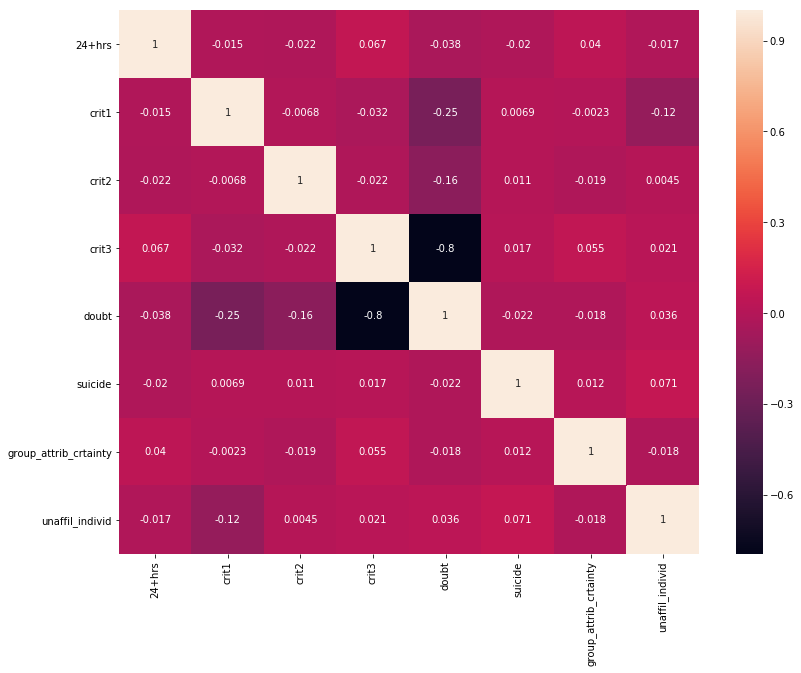

In [64]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_train_X.corr(), annot = True)
plt.show()

#### B. Success Rate for Most Active Groups:

In [65]:
# Most prolific groups:

actives = cyber_train_X['group_name'].value_counts().head(10).drop('Unknown')
mask3 = cyber_train_X['group_name'].map(lambda x: x in actives)
actives_df = cyber_train_X[mask3]

temp_output = cyber_train_Y.loc[actives_df.index]

In [66]:
# Checking to make sure I am right:
beta = pd.Series(temp_output.index != actives_df.index)

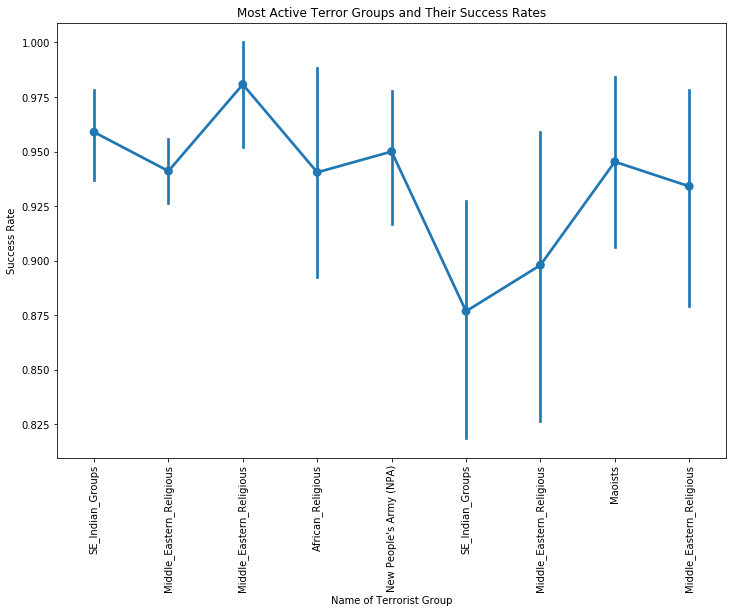

In [67]:
f, ax = plt.subplots(figsize = (12, 8))
sns.pointplot(x = actives_df['group_name'], y = temp_output.success)
ax.set_xticklabels(labels = actives_df['group_name'], rotation = '90')
ax.set_xlabel('Name of Terrorist Group')
ax.set_ylabel('Success Rate')
ax.set_title('Most Active Terror Groups and Their Success Rates')
plt.show()

#### C.  Success Rate In-Country:

In [68]:
# Most Successful Hot-Spots:
hot_countries= cyber_train_X['country_txt'].value_counts().head(10)
mask3 = cyber_train_X['country_txt'].map(lambda x: x in hot_countries)
hot_countries_df = cyber_train_X[mask3]
phi = hot_countries_df['country_txt'].value_counts().head(10)

temp_output2 = cyber_train_Y.loc[hot_countries_df.index]


In [69]:
# Checking to make sure I am right:
beta = pd.Series(temp_output2.index != hot_countries_df.index)
# beta.value_counts()

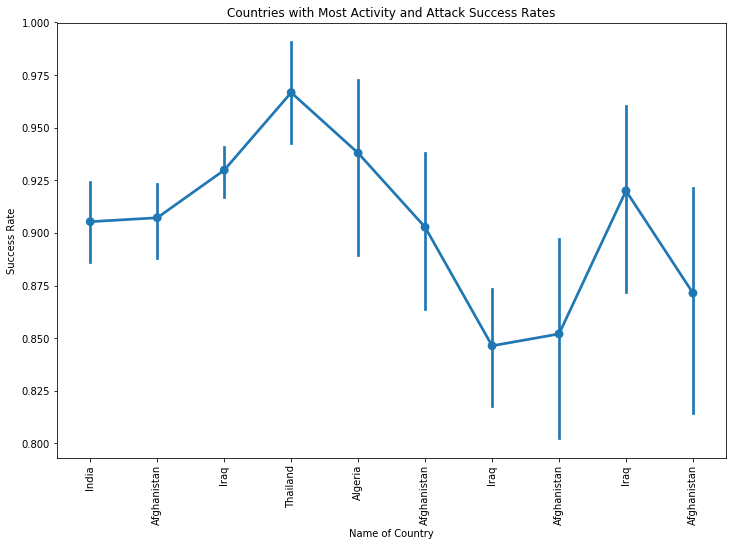

In [70]:
f, ax = plt.subplots(figsize = (12, 8))
sns.pointplot(x = hot_countries_df['country_txt'], y = temp_output2.success)
ax.set_xticklabels(labels = hot_countries_df['country_txt'], rotation = '90')
ax.set_xlabel('Name of Country')
ax.set_ylabel('Success Rate')
ax.set_title('Countries with Most Activity and Attack Success Rates')
plt.show()

### 3. Feature Selection:

> Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our data.

> We mainly focused on Select KBest within sklearn and PCA analysis to give us two perspectives on the data (one that we can parse out as humans, namely Select KBest, and one that is mostly computationally described, namely PCA). 

#### A. Select K-Best:

In [71]:
# Scouting out the null situation first to make sure we are still where we need to be:
print(cyber_train_X.shape)
train_nas = cyber_train_X.isna().sum()

print(cyber_test_X.shape)
test_nas = cyber_test_X.isna().sum()

(7114, 19)
(2372, 19)


> Since the null values are relatively few, we will go ahead and drop them from the input dataframes.  It seems that this would be better than imputing the modes at this point.

##### Assessing the Overall DataFrame and its Features:

In [72]:
from sklearn import feature_selection

In [73]:
# Getting dummies on our training and test sets (slight wrangling involved):
  # First dropping any na's:
cyber_train_X.dropna(axis = 0, inplace = True)
cyber_test_X.dropna(axis = 0, inplace = True)

  # Then grabbing an index to make sure we maintain our train/test split:
train_index = cyber_train_X.index
test_index = cyber_test_X.index

  # Dummy-time (we combined the dataframes here to make sure we didn't get duplicated dummies in both 
    # training and test sets):
dummy_prep = pd.concat([cyber_train_X, cyber_test_X]).drop(['group_name', 'city', 'weapontxt'], axis = 1)
dummy_1 = pd.get_dummies(dummy_prep)

  # Re-filtering our Training/Test Inputs:
cyber_train_dummy_X = dummy_1.loc[train_index]
cyber_test_dummy_X = dummy_1.loc[test_index]

  # Re-filtering our Training/Test Outputs:
cyber_train_dummy_Y = cyber_train_Y.loc[train_index]
cyber_test_dummy_Y = cyber_test_Y.loc[test_index]

In [74]:
# Making sure we have the same sizes still:
print(cyber_train_dummy_X.shape)
print(cyber_test_dummy_X.shape)

(6187, 5356)
(2069, 5356)


In [75]:
# Fitting SelectKBest to our Features and output:
  # Here we tried a number of sizes: 20, 30, 500 and 700. We found that 25-30 got us the best results.
KBest_1 = feature_selection.SelectKBest(k = 25) 
cyber_train_KBest1 = KBest_1.fit_transform(cyber_train_dummy_X, cyber_train_dummy_Y)

# Transforming the test-set
cyber_test_KBest1 = KBest_1.transform(cyber_test_dummy_X)

In [76]:
# Creating a DF with the top 25 features:
feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy_X.columns[feature_mask])

# Summarizing the scores for those top 25 features in a df:
KBest_1_features['P_Vals'] = KBest_1.pvalues_[0:25]
KBest_1_features['Scores'] = KBest_1.scores_[0:25]

print('Here is a dataframe with the top 25 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_1_features

Here is a dataframe with the top 25 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,24+hrs,6.713216e-12,47.293124
1,country_txt_Ireland,3.607332e-01,0.835463
2,country_txt_United Kingdom,1.832266e-01,1.771654
3,region_txt_Western Europe,1.315233e-05,19.019005
4,attack_1txt_Assassination,3.488218e-06,21.566583
5,attack_1txt_Bombing/Explosion,3.715689e-02,4.345083
6,attack_1txt_Hostage Taking (Kidnapping),5.293248e-01,0.395732
7,attack_1txt_Unknown,9.670020e-01,0.001712
8,target_1txt_Military,1.315620e-03,10.329932
9,target_1txt_Private Citizens & Property,1.134636e-01,2.506014


Here, we are getting a lot of return from the attack, target, sub-target, country, victim-nationality and country features.  The 24+hr variable is highly correlated with success, given that this column indicates whether or not an incident lasted longer than 24 hours or not. Given this high correlation, it could be useful in a setting which allows for longer analysis, but for now, we will try to fish out significance from other features.  The doubt column indicates whether doubt exists regarding the classification of this incident as a terrorist incident, as opposed to some sort of other crime.  Again, high-correlation here would make sense, but for now, we will focus on the columns below as these two top features are arguably over-correlated.

##### Assessing Individual Features:

> Running SelectKBest on a few features individually to see which of their values is selected as most important.  This will help us consolidate some of those values and make a more specific dataframe. 


> ###### Group_name:

In [77]:
# Getting dummies on our training and test sets (slight wrangling involved):
names_train_X = cyber_train_X['group_name']
names_test_X = cyber_test_X['group_name']

names_train_index = cyber_train_X['group_name'].index
names_test_index = cyber_test_X['group_name'].index

names_dummy_prep = pd.concat([names_train_X, names_test_X])
names_dummy_1 = pd.get_dummies(names_dummy_prep)

# Filtering Training/Test Inputs:
names_train_dummy_X = names_dummy_1.loc[names_train_index]
names_test_dummy_X = names_dummy_1.loc[names_test_index]

# Filtering Training Outputs:
names_train_dummy_Y = cyber_train_Y.loc[names_train_index]
names_test_dummy_Y = cyber_test_Y.loc[names_test_index]

In [78]:
# Fitting model to our features and output.
  # Again, we tried 30, 50 and 150, here. It seemed like 25-30 features gave us the best results.
KBest_names = feature_selection.SelectKBest(k = 25)  
names_train_KBest = KBest_names.fit_transform(names_train_dummy_X, names_train_dummy_Y)

# Transforming our test set.
names_test_KBest = KBest_names.transform(names_test_dummy_X)

In [79]:
# Summarizing the scores for those top 25 features in a df:

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(names_train_dummy_X.columns[names_mask])

KBest_names_features['P_Vals'] = KBest_names.pvalues_[0:25]
KBest_names_features['Scores'] = KBest_names.scores_[0:25]

print('Here is a dataframe with the top 25 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_names_features   

Here is a dataframe with the top 25 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,African_Religious,0.764657,0.089631
1,Armed Commandos of Liberation,0.764657,0.089631
2,Bangladesh Nationalist Party (BNP),0.764657,0.089631
3,Besi Merah Putih Militia,NaN,NaN
4,Black Liberation Army,0.764657,0.089631
5,Communist Party of Nepal-Maoist (Baidya),0.764657,0.089631
6,Dima Halao Daoga (DHD),0.764657,0.089631
7,Hekla Reception Committee-Initiative for More ...,0.671996,0.179294
8,Informal Anarchist Federation,0.764657,0.089631
9,Irish_Separatists,0.764657,0.089631


It looks like some of our groupings from above made it into the top-25 features, which is reassuring that our efforts above produced a result.  This also gives us a slightly broader view of the terrorist groups that are highly active, as opposed to overly-specific groups that might wash out the activity in other countries.

This also points to another issue for consideration when performing future work on the dataset. When making these groups and filters, one will want to be sure to create groups that consider as much of the globe as possible. Otherwise, one would run the risk of coagulating a few groups together from one area, thereby increasing their significance, and over-powering the significance of other groups.  The groups we created above were an attempt at creating well-represented portions of the globe.  It would benefit, however, from more time and research so as to further tweak these groupings towards a higher accuracy.

> ###### City:

In [80]:
# Getting dummies on our training and test sets (slight wrangling involved):
city_train_X = cyber_train_X['city']
city_test_X = cyber_test_X['city']

city_train_index = cyber_train_X['city'].index
city_test_index = cyber_test_X['city'].index

city_dummy_prep = pd.concat([city_train_X, city_test_X])
city_dummy_1 = pd.get_dummies(city_dummy_prep)

# Training/Test Inputs:
city_train_dummy_X = city_dummy_1.loc[city_train_index]
city_test_dummy_X = city_dummy_1.loc[city_test_index]

# Training Output:
city_train_dummy_Y = cyber_train_Y.loc[city_train_index]
city_test_dummy_Y = cyber_test_Y.loc[city_test_index]

In [81]:
# Fitting model to our features and output.
KBest_city = feature_selection.SelectKBest(k = 25) # Tried 30 and 150. 25-30 was our best range.
city_train_KBest = KBest_city.fit_transform(city_train_dummy_X, city_train_dummy_Y)

# Transforming our test set:
city_test_KBest = KBest_city.transform(city_test_dummy_X)

In [82]:
# Summarizing the scores for those top 25 features in a df:
pd.set_option('max_rows', 101)
city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy_X.columns[city_mask])

KBest_city_features['P_Vals'] = KBest_city.pvalues_[0:25]
KBest_city_features['Scores'] = KBest_city.scores_[0:25]

print('Here is a dataframe with the top 25 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
pd.set_option('max_rows', 51)
KBest_city_features   

Here is a dataframe with the top 25 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Aguada,0.764657,0.089631
1,Antrim,0.764657,0.089631
2,Belfast,0.031532,4.625883
3,Bosaso,0.764657,0.089631
4,Chukitong,0.764657,0.089631
5,Doaba,0.764657,0.089631
6,Dublin,0.479958,0.499019
7,Frankfurt,NaN,NaN
8,Gilgit,0.764657,0.089631
9,Imphal,0.764657,0.089631


Here, you can see that our Sunni-Shia split group made it into the running. This helps broaden our perspective as to what cities are undergoing what types of terrorist attacks and why.  In other words, it gives another dimension to this specific feature.

> ###### Weapontxt (weapon_train_dummy/weapon_train_output2):

In [83]:
# Getting dummies on our training and test sets (slight wrangling involved):
weapon_train_X = cyber_train_X['weapontxt']
weapon_test_X = cyber_test_X['weapontxt']

weapon_train_index = cyber_train_X['weapontxt'].index
weapon_test_index = cyber_test_X['weapontxt'].index

weapon_dummy_prep = pd.concat([weapon_train_X, weapon_test_X])
weapon_dummy_1 = pd.get_dummies(weapon_dummy_prep)

# Training/Test Inputs:
weapon_train_dummy_X = weapon_dummy_1.loc[weapon_train_index]
weapon_test_dummy_X = weapon_dummy_1.loc[weapon_test_index]

# Training Output:
weapon_train_dummy_Y = cyber_train_Y.loc[weapon_train_index]
weapon_test_dummy_Y = cyber_test_Y.loc[weapon_test_index]

In [84]:
# Fitting the model to our features and training output:

KBest_weapon = feature_selection.SelectKBest(k = 3) # Tried 5, but 3 was best.
weapon_train_KBest = KBest_weapon.fit_transform(weapon_train_dummy_X, weapon_train_dummy_Y)

# Transforming our test set:
weapon_test_KBest = KBest_weapon.transform(weapon_test_dummy_X)

In [85]:
# Summarizing the scores for those top 3 features in a df:

weapon_mask = KBest_weapon.get_support(indices = True)
KBest_weapon_features = pd.DataFrame(weapon_train_dummy_X.columns[weapon_mask])

KBest_weapon_features['P_Vals'] = KBest_weapon.pvalues_[0:3]
KBest_weapon_features['Scores'] = KBest_weapon.scores_[0:3]

print('Here is a dataframe with the top 3 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_weapon_features   

Here is a dataframe with the top 3 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Explosives,8.346424e-04,11.173553
1,Incendiary,2.680955e-08,31.005674
2,Melee,2.758744e-02,4.855964


From here, we can infer that while the data-set we are looking at somehow has consequences for cyber infrastructre or networks (including email and social networks as well as the physical networks), there seems to be a correlation with bombings and incendiary methods as well.  As such, we cannot rule out the possibility that cyber-related attacks are often related to physical or other forms of terrorist attacks (at least in the current analysis we are doing here).

#### B. Principle Component Analysis:

> ##### Assessing the Overall DataFrame:

In [86]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):
PCA_1 = PCA(n_components = 25)  # Tried 30 and 500
cyber_train_PCA = PCA_1.fit_transform(cyber_train_dummy_X)  
cyber_test_PCA = PCA_1.transform(cyber_test_dummy_X)

PCA_1_df = pd.DataFrame(data = PCA_1.singular_values_)
PCA_1_df['Explained_Variance'] = PCA_1.explained_variance_
PCA_1_df['Explained_Variance_Ratio'] = PCA_1.explained_variance_ratio_
PCA_1_df['Noise_Variance'] = PCA_1.noise_variance_
PCA_1_df = PCA_1_df.rename(columns = {0:'Singular_Vals'})


> ##### Assessing Individual Features

> ###### Group_name (names_train/test_PCA):

In [87]:
# Now looking at group_name values:
PCA_name = PCA(n_components = 25) # Tried 30 and 150
name_train_PCA = PCA_name.fit_transform(names_train_dummy_X)
name_test_PCA = PCA_name.transform(names_test_dummy_X)

PCA_name_df = pd.DataFrame(data = PCA_name.singular_values_)
PCA_name_df['Explained_Variance'] = PCA_name.explained_variance_
PCA_name_df['Explained_Variance_Ratio'] = PCA_name.explained_variance_ratio_
PCA_name_df['Noise_Variance'] = PCA_name.noise_variance_
PCA_name_df = PCA_name_df.rename(columns = {0:'Singular_Vals'})

> ###### City:

In [88]:
# Then some city stuff:
PCA_cities = PCA(n_components = 25) # Tried 30 and 150
cities_train_PCA = PCA_cities.fit_transform(city_train_dummy_X)
cities_test_PCA = PCA_cities.transform(city_test_dummy_X)

PCA_cities_df = pd.DataFrame(PCA_cities.singular_values_)
PCA_cities_df['Explained_Variance'] = PCA_cities.explained_variance_
PCA_cities_df['Explained_Variance_Ratio'] = PCA_cities.explained_variance_ratio_
PCA_cities_df['Noise_Variance'] = PCA_cities.noise_variance_
PCA_cities_df = PCA_cities_df.rename(columns = {0:'Singular_Vals'})

> ###### Weapontxt:

In [89]:
# Group_subweapon:
PCA_weapon = PCA(n_components = 3)  # Tried 5
weapon_train_PCA = PCA_weapon.fit_transform(weapon_train_dummy_X)
weapon_test_PCA = PCA_weapon.transform(weapon_test_dummy_X)

# Summarizing the scores for those top 30 features in a df:
PCA_weapon_df = pd.DataFrame(PCA_weapon.singular_values_)
PCA_weapon_df['Explained_Variance'] = PCA_weapon.explained_variance_
PCA_weapon_df['Explained_Variance_Ratio'] = PCA_weapon.explained_variance_ratio_
PCA_weapon_df['Noise_Variance'] = PCA_weapon.noise_variance_ 
PCA_weapon_df = PCA_weapon_df.rename(columns = {0:'Singular_Vals'})

#### C. Creating Specified DF with Selected Features:

> ##### DataFrame from KBest Algorithms:

In [90]:
# Training:
alpha = pd.DataFrame(cyber_train_KBest1, columns = KBest_1_features[0])
beta = pd.DataFrame(names_train_KBest, columns = KBest_names_features[0])
gamma = pd.DataFrame(city_train_KBest, columns = KBest_city_features[0])
delta = pd.DataFrame(weapon_train_KBest, columns = KBest_weapon_features[0])

KBest_train_X = pd.concat([alpha, beta, gamma, delta], axis = 1)

In [91]:
# Test:
alpha2 = pd.DataFrame(cyber_test_KBest1, columns = KBest_1_features[0])
beta2 = pd.DataFrame(names_test_KBest, columns = KBest_names_features[0])
gamma2 = pd.DataFrame(city_test_KBest, columns = KBest_city_features[0])
delta2 = pd.DataFrame(weapon_test_KBest, columns = KBest_weapon_features[0])

KBest_test_X = pd.concat([alpha2, beta2, gamma2, delta2], axis = 1)

> ##### DataFrame from PCA:

In [92]:
# Training:
cyber_train_PCA = pd.DataFrame(cyber_train_PCA)
name_train_PCA = pd.DataFrame(name_train_PCA)
cities_train_PCA = pd.DataFrame(cities_train_PCA)
weapon_train_PCA = pd.DataFrame(weapon_train_PCA)

PCA_train_X = pd.DataFrame()
PCA_train_X = pd.concat([cyber_train_PCA, name_train_PCA, cities_train_PCA, weapon_train_PCA], axis = 1)

In [93]:
# Test:
cyber_test_PCA = pd.DataFrame(cyber_test_PCA)
name_test_PCA = pd.DataFrame(name_test_PCA)
cities_test_PCA = pd.DataFrame(cities_test_PCA)
weapon_test_PCA = pd.DataFrame(weapon_test_PCA)

PCA_test_X = pd.DataFrame()
PCA_test_X = pd.concat([cyber_test_PCA, name_test_PCA, cities_test_PCA, weapon_test_PCA], axis = 1)

### 4. Preliminary Models:

> Starting with a simple Logistic Regression since our output feature is binary. Afterwards, we will move on to our Random Forest, Support Vector Classifier and Gradient Booster. We chose these models since they often work will with binary output features.

#### Logistic Regression:

##### KBest Features:

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import cross_val_score

KBest_logistic = LogisticRegression()

KBest_logistic = KBest_logistic.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_train_pred_ = KBest_logistic.predict(KBest_train_X)
KBest_logistic_test_pred_ = KBest_logistic.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_logistic_train_pred_, labels = [0, 1])
KBest_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_logistic_cv = cross_val_score(KBest_logistic, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_logistic_train_score = KBest_logistic.score(KBest_train_X, cyber_train_dummy_Y)
KBest_logistic_test_score = KBest_logistic.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_logistic_train_pred_)    
KBest_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_logistic_test_pred_)    

In [95]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_logistic_cv.mean(),
                                                                     plusminus, KBest_logistic_cv.std()))
print("The cv scores are: {}".format(KBest_logistic_cv))

conf_df = pd.DataFrame(KBest_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_logistic_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_logistic_train))

conf_df2 = pd.DataFrame(KBest_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_logistic_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_logistic_test))


The mean cross-validation score is: 93.74% ±0.37%
The cv scores are: [0.93699515 0.93457189 0.94345719 0.93290218 0.93932039]

Training-Set Metrics:
The training score is: 93.94%

     0     1
0  196   313
1   62  5616

False Positive/Type I Error: 313 (61.49%)
False Negative/Type II Error: 62 (1.09%)
Balanced Accuracy: 68.71%

Test-Set Metrics:
The test score is: 93.72%

    0     1
0  58   111
1  19  1881

False Positive/Type I Error: 111 (65.68%)
False Negative/Type II Error: 19 (1.00%)
Balanced Accuracy: 66.66%


##### PCA Features:

In [96]:
PCA_logistic = LogisticRegression()

PCA_logistic = PCA_logistic.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_train_pred_ = PCA_logistic.predict(PCA_train_X)
PCA_logistic_test_pred_ = PCA_logistic.predict(PCA_test_X)

# Evaluation:
  # Confustion Matrices:    
PCA_logistic_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_logistic_train_pred_, labels = [0, 1])
PCA_logistic_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_logistic_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_logistic_cv = cross_val_score(PCA_logistic, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_logistic_train_score = PCA_logistic.score(PCA_train_X, cyber_train_dummy_Y)
PCA_logistic_test_score = PCA_logistic.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
PCA_logistic_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_logistic_train_pred_)    
PCA_logistic_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_logistic_test_pred_)    

In [97]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_logistic_cv.mean(),
                                                                     plusminus, PCA_logistic_cv.std()))
print("The cv scores are: {}".format(PCA_logistic_cv))

conf_df = pd.DataFrame(PCA_logistic_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_logistic_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_logistic_train))

conf_df2 = pd.DataFrame(PCA_logistic_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_logistic_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_logistic_test))


The mean cross-validation score is: 93.23% ±0.46%
The cv scores are: [0.93780291 0.92568659 0.93699515 0.93128537 0.92961165]

Training-Set Metrics:
The training score is: 93.52%

     0     1
0  185   324
1   77  5601

False Positive/Type I Error: 324 (63.65%)
False Negative/Type II Error: 77 (1.36%)
Balanced Accuracy: 67.49%

Test-Set Metrics:
The test score is: 92.94%

    0     1
0  50   119
1  27  1873

False Positive/Type I Error: 119 (70.41%)
False Negative/Type II Error: 27 (1.42%)
Balanced Accuracy: 64.08%


Now, while we do have some decent scores here, especially regarding the true positive predictions, we do have a class imbalance issue we will need to take into consideration (as demonstrated below).  One way of doing that will work on increasing the accuracy of our true negatives and focusing less on our true positives. It will also help to take into consideration our False Negatives and Positives. Lowering these will help strengthen our model and give us more predictive integrity.  In other words, we want to make sure we avoid as many False Negatives (i.e. instances where our model does not predict a terrorist attack, when instead one does, in fact, occur) as possible.  We also want to be sure we are keeping our False Positive count as low as possible since responding to predicted terrorist incidents when there are none will exhaust resources and employees - in turn taking away their energies from realistic threats. 

In order to do so, we have implemented the Balanced Accuracy score, which gives us an average of our False Negatives and Positives.  It allows us to consider another aspect of the model results outside of the training and test-set scores (which only allow us to see on aspect of a model's predictive results).  The Balanced Accuracy is a nice addition to the confusion matrix, which gives us the hard-numbers which are factored into the Balanced Accuracy score.  In assessing the models above along with those below, we will be looking at all of these evaluation methods in order to determine which model is the best and make our reasoning as well-rounded as possible. 

In [98]:
print(cyber_train_dummy_Y.success.value_counts())
print(cyber_test_dummy_Y.success.value_counts())

1    5678
0     509
Name: success, dtype: int64
1    1900
0     169
Name: success, dtype: int64


#### Random Forest:

##### KBest Features:

In [99]:
from sklearn.ensemble import RandomForestClassifier

KBest_forest = RandomForestClassifier(n_estimators = 30, max_depth = 12)

KBest_forest = KBest_forest.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_train_pred_ = KBest_forest.predict(KBest_train_X)
KBest_forest_test_pred_ = KBest_forest.predict(KBest_test_X)

# Evaluation:
  # Confustion Matrices:    
KBest_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_forest_train_pred_, labels = [0, 1])
KBest_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_forest_cv = cross_val_score(KBest_forest, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_forest_train_score = KBest_forest.score(KBest_train_X, cyber_train_dummy_Y)
KBest_forest_test_score = KBest_forest.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_forest_train_pred_)    
KBest_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_forest_test_pred_)    
    

In [100]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_forest_cv.mean(),
                                                                     plusminus, KBest_forest_cv.std()))
print("The cv scores are: {}".format(KBest_forest_cv))

conf_df = pd.DataFrame(KBest_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_forest_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_forest_train))

conf_df2 = pd.DataFrame(KBest_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_forest_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_forest_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_forest.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))


The mean cross-validation score is: 93.65% ±0.31%
The cv scores are: [0.93941842 0.93780291 0.93780291 0.93047696 0.9368932 ]

Training-Set Metrics:
The training score is: 94.42%

     0     1
0  210   299
1   46  5632

False Positive/Type I Error: 299 (58.74%)
False Negative/Type II Error: 46 (0.81%)
Balanced Accuracy: 70.22%

Test-Set Metrics:
The test score is: 94.20%

    0     1
0  61   108
1  12  1888

False Positive/Type I Error: 108 (63.91%)
False Negative/Type II Error: 12 (0.63%)
Balanced Accuracy: 67.73%


Feature Importances:



,Importances
0,
attack_1txt_Assassination,0.23
target_1txt_Military,0.21
Explosives,0.11
attack_1txt_Bombing/Explosion,0.05
sub_weapontxt_Other Explosive Type,0.03
Unknown,0.03
sub_targettxt_Gov_Figure1,0.02
24+hrs,0.01
Antrim,0.01


##### PCA Features

In [101]:
PCA_forest = RandomForestClassifier()

PCA_forest = PCA_forest.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_train_pred_ = PCA_forest.predict(PCA_train_X)
PCA_forest_test_pred_ = PCA_forest.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_forest_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_forest_train_pred_, labels = [0, 1])
PCA_forest_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_forest_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_forest_cv = cross_val_score(PCA_forest, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_forest_train_score = PCA_forest.score(PCA_train_X, cyber_train_dummy_Y)
PCA_forest_test_score = PCA_forest.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking and balanced accuracy/f1 scores:
PCA_forest_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_forest_train_pred_)    
PCA_forest_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_forest_test_pred_)    

In [102]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_forest_cv.mean(),
                                                                     plusminus, PCA_forest_cv.std()))
print("The cv scores are: {}".format(PCA_forest_cv))

conf_df = pd.DataFrame(PCA_forest_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_forest_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_forest_train))

conf_df2 = pd.DataFrame(PCA_forest_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_forest_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_forest_test))



The mean cross-validation score is: 92.95% ±0.45%
The cv scores are: [0.93134087 0.92568659 0.92972536 0.9240097  0.9368932 ]

Training-Set Metrics:
The training score is: 99.05%

     0     1
0  469    40
1   19  5659

False Positive/Type I Error: 40 (7.86%)
False Negative/Type II Error: 19 (0.33%)
Balanced Accuracy: 95.90%

Test-Set Metrics:
The test score is: 92.90%

    0     1
0  64   105
1  42  1858

False Positive/Type I Error: 105 (62.13%)
False Negative/Type II Error: 42 (2.21%)
Balanced Accuracy: 67.83%


Here, we can see quite a bit of over-fitting given that the training score and balanced accuracy scores are nearly perfect, while the test score is about 5 percentage points lower than the training score and the balanced accuracy scorew 20 points lower (a drastic difference compared to what we have seen thus far). The nice aspect about the Random Forest, however, is that it lets us look into the feature importances which were used in creating the model, which we saw in the KBest model above.

#### Support Vector Classifier:

##### KBest Features:

In [103]:
from sklearn.svm import SVC

KBest_SVC = SVC()

KBest_SVC = KBest_SVC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_train_pred_ = KBest_SVC.predict(KBest_train_X)
KBest_SVC_test_pred_ = KBest_SVC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:
KBest_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_SVC_train_pred_, labels = [0, 1])
KBest_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_SVC_cv = cross_val_score(KBest_SVC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_SVC_train_score = KBest_SVC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_SVC_test_score = KBest_SVC.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at balanced accuracy/f1 scores:
KBest_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_SVC_train_pred_)
KBest_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_SVC_test_pred_)    

In [104]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_SVC_cv.mean(),
                                                                     plusminus, KBest_SVC_cv.std()))
print("The cv scores are: {}".format(KBest_SVC_cv))

conf_df = pd.DataFrame(KBest_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_SVC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_SVC_train))

conf_df2 = pd.DataFrame(KBest_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_SVC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_SVC_test))


The mean cross-validation score is: 93.07% ±0.68%
The cv scores are: [0.93699515 0.93295638 0.91760905 0.93128537 0.93446602]

Training-Set Metrics:
The training score is: 93.70%

     0     1
0  181   328
1   62  5616

False Positive/Type I Error: 328 (64.44%)
False Negative/Type II Error: 62 (1.09%)
Balanced Accuracy: 67.23%

Test-Set Metrics:
The test score is: 94.10%

    0     1
0  59   110
1  12  1888

False Positive/Type I Error: 110 (65.09%)
False Negative/Type II Error: 12 (0.63%)
Balanced Accuracy: 67.14%


##### PCA Features

In [105]:
PCA_SVC = SVC()

PCA_SVC = PCA_SVC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_train_pred_ = PCA_SVC.predict(PCA_train_X)
PCA_SVC_test_pred_ = PCA_SVC.predict(PCA_test_X)

# Evaluation:
  # Confusion Matrices:
PCA_SVC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_SVC_train_pred_, labels = [0, 1])
PCA_SVC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_SVC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_SVC_cv = cross_val_score(PCA_SVC, PCA_train_X, cyber_train_dummy_Y, cv = 5)
PCA_SVC_train_score = PCA_SVC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_SVC_test_score = PCA_SVC.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced accuracy scores:
PCA_SVC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_SVC_train_pred_)
PCA_SVC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_SVC_test_pred_)

In [106]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_SVC_cv.mean(),
                                                                     plusminus, PCA_SVC_cv.std()))
print("The cv scores are: {}".format(PCA_SVC_cv))

conf_df = pd.DataFrame(PCA_SVC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_SVC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_SVC_train))

conf_df2 = pd.DataFrame(PCA_SVC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_SVC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_SVC_test))


The mean cross-validation score is: 93.68% ±0.41%
The cv scores are: [0.93780291 0.93295638 0.94184168 0.93128537 0.94012945]

Training-Set Metrics:
The training score is: 93.68%

     0     1
0  182   327
1   64  5614

False Positive/Type I Error: 327 (64.24%)
False Negative/Type II Error: 64 (1.13%)
Balanced Accuracy: 67.31%

Test-Set Metrics:
The test score is: 94.01%

    0     1
0  59   110
1  14  1886

False Positive/Type I Error: 110 (65.09%)
False Negative/Type II Error: 14 (0.74%)
Balanced Accuracy: 67.09%


These support vector models are relatively stable in the sense that they are able to achieve similar test scores throughout various rounds, which is good.  The balanced accuracy scores are okay as well.  They do not, however, correctly identify as many True Negatives as our Random Forest PCA model.  Let's take a look at one more round of model-type.

#### Gradient Boosting:

##### KBest Features:

In [107]:
from sklearn.ensemble import GradientBoostingClassifier

KBest_GBC = GradientBoostingClassifier()

KBest_GBC = KBest_GBC.fit(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_train_pred_ = KBest_GBC.predict(KBest_train_X)
KBest_GBC_test_pred_ = KBest_GBC.predict(KBest_test_X)

# Evaluation:
  # Confusion matrices:    
KBest_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, KBest_GBC_train_pred_, labels = [0, 1])
KBest_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, KBest_GBC_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
KBest_GBC_cv = cross_val_score(KBest_GBC, KBest_train_X, cyber_train_dummy_Y, cv = 5)
KBest_GBC_train_score = KBest_GBC.score(KBest_train_X, cyber_train_dummy_Y)
KBest_GBC_test_score = KBest_GBC.score(KBest_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced-accuracy scores:
KBest_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, KBest_GBC_train_pred_)
KBest_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, KBest_GBC_test_pred_)

In [108]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(KBest_GBC_cv.mean(),
                                                                     plusminus, KBest_GBC_cv.std()))
print("The cv scores are: {}".format(KBest_GBC_cv))

conf_df = pd.DataFrame(KBest_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(KBest_GBC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(KBest_GBC_train))

conf_df2 = pd.DataFrame(KBest_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(KBest_GBC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(KBest_GBC_test))

print('\n\nFeature Importances:\n')
feat_imp = pd.DataFrame(KBest_GBC.feature_importances_.round(2), index = KBest_train_X.columns, 
                        columns = ["Importances"])
display(feat_imp.sort_values('Importances', ascending = False))


The mean cross-validation score is: 93.92% ±0.54%
The cv scores are: [0.94022617 0.93941842 0.94749596 0.93047696 0.93851133]

Training-Set Metrics:
The training score is: 94.60%

     0     1
0  237   272
1   62  5616

False Positive/Type I Error: 272 (53.44%)
False Negative/Type II Error: 62 (1.09%)
Balanced Accuracy: 72.73%

Test-Set Metrics:
The test score is: 94.20%

    0     1
0  66   103
1  17  1883

False Positive/Type I Error: 103 (60.95%)
False Negative/Type II Error: 17 (0.89%)
Balanced Accuracy: 69.08%


Feature Importances:



,Importances
0,
attack_1txt_Assassination,0.44
Explosives,0.15
target_1txt_Military,0.10
region_txt_Western Europe,0.02
target_1txt_Private Citizens & Property,0.02
Imphal,0.02
24+hrs,0.01
Communist Party of Nepal-Maoist (Baidya),0.01
Smile,0.01


##### PCA Features

In [109]:
PCA_GBC = GradientBoostingClassifier()

PCA_GBC = PCA_GBC.fit(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_train_pred_ = PCA_GBC.predict(PCA_train_X) 
PCA_GBC_test_pred_ = PCA_GBC.predict(PCA_test_X) 

# Evaluation:

  # Confusion matrices:
PCA_GBC_confusion_train = confusion_matrix(cyber_train_dummy_Y, PCA_GBC_train_pred_, labels = [0, 1])
PCA_GBC_confusion_test = confusion_matrix(cyber_test_dummy_Y, PCA_GBC_test_pred_, labels = [0, 1])

  # Cross_validation and train/test score:
PCA_GBC_cv = cross_val_score(PCA_GBC, PCA_train_X, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
PCA_GBC_train_score = PCA_GBC.score(PCA_train_X, cyber_train_dummy_Y)
PCA_GBC_test_score = PCA_GBC.score(PCA_test_X, cyber_test_dummy_Y)

  # Looking at the F1/balanced accuracy scores:
PCA_GBC_train = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC_train_pred_)
PCA_GBC_test = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC_test_pred_)

In [110]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv.mean(),
                                                                     plusminus, PCA_GBC_cv.std()))
print("The cv scores are: {}".format(PCA_GBC_cv))

conf_df = pd.DataFrame(PCA_GBC_confusion_train)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_GBC_train_score))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train))

conf_df2 = pd.DataFrame(PCA_GBC_confusion_test)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_GBC_test_score))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test))


The mean cross-validation score is: 96.44% ±0.20%
The cv scores are: [0.96584522 0.96286701 0.96602151 0.96110631 0.96593359]

Training-Set Metrics:
The training score is: 95.28%

     0     1
0  263   246
1   46  5632

False Positive/Type I Error: 246 (48.33%)
False Negative/Type II Error: 46 (0.81%)
Balanced Accuracy: 75.43%

Test-Set Metrics:
The test score is: 93.77%

    0     1
0  62   107
1  22  1878

False Positive/Type I Error: 107 (63.31%)
False Negative/Type II Error: 22 (1.16%)
Balanced Accuracy: 67.76%


#### Summary of First Models:

> Based on these preliminary results, it looks like our best models are the Random Forest and Gradient Booster, more specifically with our PCA features. While the Support Vector model also provided solid results, the difference between the test and training sets was relatively small and while this is usually a good aspect, we wonder if the training accuracy of the other models can be tweaked to transfer to their test sets, especially since they were able to lessen the amount of False Negatives and Positives overall.  As such, we will go ahead and focus on the Random Forest and Gradient Boosters with our PCA selected features.

### 5. Improving our Scores:

#### A. Investigating the Data Itself:

> Here, we will poke around at the areas of the data where an attack was unsuccessful (i.e. Success == 0), so as to try and improve our false prediction score. In doing so, we will take a step back and look at our cyber_data set in general. This should give us some generalized, top-level perspective on this subset of attacks.  While we will mainly be using our PCA feature-set based on the scores above, we will also consider the K-Best features we received to look at some more specific columns that may merit more attention.

##### Revisiting the larger data-set:

In [111]:
# Isolated dataframe so we can take a look:
fails = cyber_data.loc[cyber_data['success'] == 0]
successes = cyber_data.loc[cyber_data['success'] == 1]

In [112]:
fails.group_name.value_counts()
successes.group_name.value_counts()
fails.describe(include = 'O')

,country_txt,region_txt,region_2,city,summary,attack_1txt,target_1txt,sub_targettxt,corp1,specific_target,victim_nationalitytxt,group_name,motive,weapontxt,sub_weapontxt
count,885,885,885,883,885,885,885,717,805,882,830,885,885,885,847
unique,55,10,237,528,879,9,16,75,397,616,57,95,167,9,25
top,Iraq,South Asia,Khyber Pakhtunkhwa,Unknown,05/06/2013: Assailants opened fire on the priv...,Bombing/Explosion,Military,"Government Personnel (excluding police, military)",Unknown,Unknown,Iraq,Unknown,nan,Explosives,Unknown Explosive Type
freq,168,382,49,52,3,454,322,124,197,158,164,626,451,696,268


In [113]:
unknown_groups_fail = fails.loc[fails['group_name'] == 'Unknown']
unknown_groups_success = successes.loc[successes['group_name'] == 'Unknown']

#### B. Last bit of feature-engineering:

##### Attack success rate by group:

In [124]:
# Placing our success feature back into a temporary data-frame so we can perform some engineering:
temp_df1 = cyber_train_X.join(cyber_train_Y['success'])

  # Getting total attacks made by each group:
success_totals = temp_df1.groupby('group_name').transform('count')
temp_df1['grp_attack_ttl'] = success_totals['success']

 # Getting the amount of those attacks which were successful:
temp_df1['grp_attack_successes'] = temp_df1.groupby('group_name').transform('sum')['success']

  # Creating a feature which represents the percentage of successful attacks for each group:
temp_df1['grp_success_pct'] = temp_df1['grp_attack_successes'] / temp_df1['grp_attack_ttl']

In [125]:
# Performing the same engineering on our test-set:
temp_df2 = cyber_test_X.join(cyber_test_Y['success'])

success_totals2 = temp_df2.groupby('group_name').transform('count')
temp_df2['grp_attack_ttl'] = success_totals2['success']

temp_df2['grp_attack_successes'] = temp_df2.groupby('group_name').transform('sum')['success']

temp_df2['grp_success_pct'] = temp_df2['grp_attack_successes'] / temp_df2['grp_attack_ttl']

##### Attack success rate by target:

In [126]:
# Getting the total attack number for each sub-target type:
sub_targ_totals = temp_df1.groupby('sub_targettxt').transform('count')
temp_df1['subtrgt_attack_ttl'] = sub_targ_totals['success']

  # Getting the total of successful attacks each sub-target experienced:
temp_df1['subtrgt_attack_successes'] = temp_df1.groupby('sub_targettxt').transform('sum')['success']

  # Getting the percentage of successful attacks for each target:
temp_df1['subtrgt_success_pct'] = temp_df1['subtrgt_attack_successes'] / temp_df1['subtrgt_attack_ttl']

In [127]:
# Now doing the same for our test-set:
sub_targ_totals2 = temp_df2.groupby('sub_targettxt').transform('count')
temp_df2['subtrgt_attack_ttl'] = sub_targ_totals2['success']

temp_df2['subtrgt_attack_successes'] = temp_df2.groupby('sub_targettxt').transform('sum')['success']

temp_df2['subtrgt_success_pct'] = temp_df2['subtrgt_attack_successes'] / temp_df2['subtrgt_attack_ttl']

##### Percentage of successful attacks attributed to each group with certainty:

In [128]:
# Going with our group total attack number again:
doubt_totals = temp_df1.groupby('group_name').transform('count')

  # Getting the number of these that were successful:
temp_df1['doubt_ttl'] = doubt_totals['success']
  # Then summing up the number of these that fell into or out of the certainty feature:
temp_df1['doubt_count'] = temp_df1.groupby('sub_targettxt').transform('sum')['group_attrib_crtainty']
  # Then calculating the percentage of these that fell into the groups successful attacks category:
     # (I.e. the percentage of successful attacks that were able to be identified with certainty)
temp_df1['doubt_pct'] = temp_df1['doubt_count'] / temp_df1['doubt_ttl']

In [129]:
doubt_totals2 = temp_df2.groupby('group_name').transform('count')

temp_df2['doubt_ttl'] = doubt_totals2['success']

temp_df2['doubt_count'] = temp_df2.groupby('sub_targettxt').transform('sum')['group_attrib_crtainty']

temp_df2['doubt_pct'] = temp_df2['doubt_count'] / temp_df2['doubt_ttl']

##### Putting it back into PCA Model Form:

> Thus, the cells above have engineerd some more features based on 'success', 'target' and 'grp_attrib_certainty' since we wanted to increase our understanding of unsuccessful attacks and since our KBest feature selection pointed out the importance of target features.  We then drop them from our training and test sets so as not to duplicate any data:

In [130]:
cyber_train_X['grp_attack_ttl'] = temp_df1['grp_attack_ttl']
cyber_train_X['grp_success_pct'] = temp_df1['grp_success_pct']
cyber_train_X['subtrgt_attack_ttl'] = temp_df1['subtrgt_attack_ttl']
cyber_train_X['subtrgt_success_pct'] = temp_df1['subtrgt_success_pct']
cyber_train_X['doubt_ttl'] = temp_df1['doubt_ttl']
cyber_train_X['doubt_pct'] = temp_df1['doubt_pct']

cyber_test_X['grp_attack_ttl'] = temp_df2['grp_attack_ttl']
cyber_test_X['grp_success_pct'] = temp_df2['grp_success_pct']
cyber_test_X['subtrgt_attack_ttl'] = temp_df2['subtrgt_attack_ttl']
cyber_test_X['subtrgt_success_pct'] = temp_df2['subtrgt_success_pct']
cyber_test_X['doubt_ttl'] = temp_df2['doubt_ttl']
cyber_test_X['doubt_pct'] = temp_df2['doubt_pct']


In [131]:
# Checked for NA's first - we are set.
# Getting indices just for good measure:
train_index2 = cyber_train_X.index
test_index2 = cyber_test_X.index

# Combining our train/test set for only a second (to avoid duplicating dummy rows):
dummy_prep2 = pd.concat([cyber_train_X, cyber_test_X]).drop(['24+hrs', 'group_name', 'city', 'target_1txt'], axis = 1)
dummy2 = pd.get_dummies(dummy_prep2)

# Re-splitting our data:
cyber_train_dummy_X2 = dummy2.loc[train_index2]
cyber_test_dummy_X2 = dummy2.loc[test_index2]

In [132]:
# Components from the whole data frame:

PCA_2 = PCA(n_components = 50)  
cyber_train_PCA2 = PCA_2.fit_transform(cyber_train_dummy_X2) 
cyber_test_PCA2 = PCA_2.transform(cyber_test_dummy_X2)

In [133]:
# Group_name components:

  # Indices and dummies:
names_train_X2 = cyber_train_X['group_name']
names_test_X2 = cyber_test_X['group_name']

names_train_index2 = cyber_train_X['group_name'].index
names_test_index2 = cyber_test_X['group_name'].index

names_dummy_prep2 = pd.concat([names_train_X2, names_test_X2])
names_dummy_2 = pd.get_dummies(names_dummy_prep2)
  
  # Training/Test Inputs:

names_train_dummy_X2 = names_dummy_2.loc[names_train_index2]
names_test_dummy_X2 = names_dummy_2.loc[names_test_index2]

  # Training Output:

names_train_dummy_Y2 = cyber_train_Y.loc[names_train_index2]
names_test_dummy_Y2 = cyber_test_Y.loc[names_test_index2]

PCA_names2 = PCA(n_components = 50)  
train_names_PCA2 = PCA_names2.fit_transform(names_train_dummy_X2) 
test_names_PCA2 = PCA_names2.transform(names_test_dummy_X2)

In [134]:
# City components:

  # Indices and dummies:
cities_train_X2 = cyber_train_X['group_name']
cities_test_X2 = cyber_test_X['group_name']

cities_train_index2 = cyber_train_X['group_name'].index
cities_test_index2 = cyber_test_X['group_name'].index

cities_dummy_prep2 = pd.concat([cities_train_X2, cities_test_X2])
cities_dummy_2 = pd.get_dummies(cities_dummy_prep2)
  
  # Training/Test Inputs:

cities_train_dummy_X2 = cities_dummy_2.loc[cities_train_index2]
cities_test_dummy_X2 = cities_dummy_2.loc[cities_test_index2]

  # Training Output:

cities_train_dummy_Y2 = cyber_train_Y.loc[cities_train_index2]
cities_test_dummy_Y2 = cyber_test_Y.loc[cities_test_index2]

PCA_cities2 = PCA(n_components = 50)  
train_cities_PCA2 = PCA_cities2.fit_transform(cities_train_dummy_X2) 
test_cities_PCA2 = PCA_cities2.transform(cities_test_dummy_X2)

In [135]:
# Target components:

  # Indices and dummies:
subtargs_train_X2 = cyber_train_X['group_name']
subtargs_test_X2 = cyber_test_X['group_name']

subtargs_train_index2 = cyber_train_X['group_name'].index
subtargs_test_index2 = cyber_test_X['group_name'].index

subtargs_dummy_prep2 = pd.concat([subtargs_train_X2, subtargs_test_X2])
subtargs_dummy_2 = pd.get_dummies(subtargs_dummy_prep2)
  
  # Training/Test Inputs:

subtargs_train_dummy_X2 = subtargs_dummy_2.loc[subtargs_train_index2]
subtargs_test_dummy_X2 = subtargs_dummy_2.loc[subtargs_test_index2]

  # Training Output:

subtargs_train_dummy_Y2 = cyber_train_Y.loc[subtargs_train_index2]
subtargs_test_dummy_Y2 = cyber_test_Y.loc[subtargs_test_index2]

PCA_subtargs2 = PCA(n_components = 50)  
train_subtargs_PCA2 = PCA_subtargs2.fit_transform(subtargs_train_dummy_X2) 
test_subtargs_PCA2 = PCA_subtargs2.transform(subtargs_test_dummy_X2)

In [136]:
whole_train_df = pd.DataFrame(cyber_train_PCA2)
names_train_df = pd.DataFrame(train_names_PCA2)
cities_train_df = pd.DataFrame(train_cities_PCA2)
subtargs_train_df = pd.DataFrame(train_subtargs_PCA2)

PCA_train_X2 = pd.DataFrame()
PCA_train_X2 = pd.concat([whole_train_df, names_train_df, cities_train_df, subtargs_train_df], axis = 1)

In [137]:
whole_test_df = pd.DataFrame(cyber_test_PCA2)
names_test_df = pd.DataFrame(test_names_PCA2)
cities_test_df = pd.DataFrame(test_cities_PCA2)
subtargs_test_df = pd.DataFrame(test_subtargs_PCA2)

PCA_test_X2 = pd.DataFrame()
PCA_test_X2 = pd.concat([whole_test_df, names_test_df, cities_test_df, subtargs_test_df], axis = 1)

### 6. Final Random Forest and Gradient Booster Models:

#### A. Random Forest:

In [138]:
PCA_forest2 = RandomForestClassifier()

PCA_forest2 = PCA_forest2.fit(PCA_train_X2, cyber_train_dummy_Y)
PCA_forest2_train_pred_ = PCA_forest2.predict(PCA_train_X2)
PCA_forest2_test_pred_ = PCA_forest2.predict(PCA_test_X2)

# Evaluation:
  # Confusion Matrices:
PCA_forest_confusion_train2 = confusion_matrix(cyber_train_dummy_Y, PCA_forest2_train_pred_, labels = [0, 1])
PCA_forest_confusion_test2 = confusion_matrix(cyber_test_dummy_Y, PCA_forest2_test_pred_, labels = [0, 1])

  # Cross-validation and train/test scores:
PCA_forest_cv2 = cross_val_score(PCA_forest2, PCA_train_X2, cyber_train_dummy_Y, cv = 5)
PCA_forest_train_score2 = PCA_forest2.score(PCA_train_X2, cyber_train_dummy_Y)
PCA_forest_test_score2 = PCA_forest2.score(PCA_test_X2, cyber_test_dummy_Y)

  # Looking and balanced accuracy/f1 scores:
PCA_forest_train2 = balanced_accuracy_score(cyber_train_dummy_Y, PCA_forest2_train_pred_)    
PCA_forest_test2 = balanced_accuracy_score(cyber_test_dummy_Y, PCA_forest2_test_pred_)    

In [139]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_forest_cv2.mean(),
                                                                     plusminus, PCA_forest_cv2.std()))
print("The cv scores are: {}".format(PCA_forest_cv2))

conf_df = pd.DataFrame(PCA_forest_confusion_train2)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_forest_train_score2))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_forest_train2))

conf_df2 = pd.DataFrame(PCA_forest_confusion_test2)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_forest_test_score2))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_forest_test2))



The mean cross-validation score is: 92.58% ±0.45%
The cv scores are: [0.92407108 0.92487884 0.93457189 0.92239289 0.92313916]

Training-Set Metrics:
The training score is: 98.35%

     0     1
0  441    68
1   34  5644

False Positive/Type I Error: 68 (13.36%)
False Negative/Type II Error: 34 (0.60%)
Balanced Accuracy: 93.02%

Test-Set Metrics:
The test score is: 93.14%

    0     1
0  41   128
1  14  1886

False Positive/Type I Error: 128 (75.74%)
False Negative/Type II Error: 14 (0.74%)
Balanced Accuracy: 61.76%


#### B. Gradient Booster:

In [140]:
PCA_GBC2 = GradientBoostingClassifier()

PCA_GBC2 = PCA_GBC2.fit(PCA_train_X2, cyber_train_dummy_Y)
PCA_GBC2_train_pred_ = PCA_GBC2.predict(PCA_train_X2) 
PCA_GBC2_test_pred_ = PCA_GBC2.predict(PCA_test_X2) 

# Evaluation:

  # Confusion matrices:
PCA_GBC_confusion_train2 = confusion_matrix(cyber_train_dummy_Y, PCA_GBC2_train_pred_, labels = [0, 1])
PCA_GBC_confusion_test2 = confusion_matrix(cyber_test_dummy_Y, PCA_GBC2_test_pred_, labels = [0, 1])

  # Cross_validation and train/test score:
PCA_GBC_cv2 = cross_val_score(PCA_GBC2, PCA_train_X2, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
PCA_GBC_train_score2 = PCA_GBC2.score(PCA_train_X2, cyber_train_dummy_Y)
PCA_GBC_test_score2 = PCA_GBC2.score(PCA_test_X2, cyber_test_dummy_Y)

  # Looking at the F1/balanced accuracy scores:
PCA_GBC_train2 = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC2_train_pred_)
PCA_GBC_test2 = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC2_test_pred_)

In [141]:
plusminus = u"\u00B1"
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv2.mean(),
                                                                     plusminus, PCA_GBC_cv2.std()))
print("The cv scores are: {}".format(PCA_GBC_cv2))

conf_df = pd.DataFrame(PCA_GBC_confusion_train2)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print("\nTraining-Set Metrics:")
print("The training score is: {:.2%}\n".format(PCA_GBC_train_score2))
print(conf_df)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train2))

conf_df2 = pd.DataFrame(PCA_GBC_confusion_test2)

FP2 = conf_df2.loc[0, 1]
FN2 = conf_df2.loc[1, 0]
NegT2 = conf_df2.iloc[0].sum()
PosT2 = conf_df2.iloc[1].sum()

print("Test-Set Metrics:")
print("The test score is: {:.2%}\n".format(PCA_GBC_test_score2))
print(conf_df2)
print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP2, (FP2 / NegT2)))
print('False Negative/Type II Error: {} ({:.2%})'.format(FN2, (FN2 / PosT2)))
print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test2))


The mean cross-validation score is: 96.27% ±0.26%
The cv scores are: [0.96751841 0.96086022 0.96302666 0.96210164 0.9600687 ]

Training-Set Metrics:
The training score is: 95.28%

     0     1
0  258   251
1   41  5637

False Positive/Type I Error: 251 (49.31%)
False Negative/Type II Error: 41 (0.72%)
Balanced Accuracy: 74.98%

Test-Set Metrics:
The test score is: 93.48%

    0     1
0  49   120
1  15  1885

False Positive/Type I Error: 120 (71.01%)
False Negative/Type II Error: 15 (0.79%)
Balanced Accuracy: 64.10%


Initially, these are only marginally better than what we had before, so our next step is to tweak our model parameters.  We will start with our Gradient Booster since it gave sligthly better results than the random forest model:

#### C. Investigating and Visualizing Model Parameters:

Here, we will try and use a for loop to run through a set of parameters, which we will then use to visualize the parameters which will optimize our model's predictive power.  For the moment, the parameters we will focus on are the 'learning_rate', 'n_estimators', 'sub_sample' and 'max_depth.'

In [220]:
param_dict = {'n_estimators': [165, 165, 165, 165],
              'max_depth': [13, 12, 11, 10]}

param_df = pd.DataFrame(param_dict)
param_df

,n_estimators,max_depth
0,165,13
1,165,12
2,165,11
3,165,10


In [221]:
results_list = []

for row in param_df.itertuples(index = False):

    PCA_GBC3 = RandomForestClassifier(n_estimators = row[0],
                                          criterion = 'entropy',
                                          max_depth = row[1])

    PCA_GBC3 = PCA_GBC3.fit(PCA_train_X2, cyber_train_dummy_Y)
    PCA_GBC3_train_pred_ = PCA_GBC3.predict(PCA_train_X2) 
    PCA_GBC3_test_pred_ = PCA_GBC3.predict(PCA_test_X2) 

    # Evaluation:

      # Confusion matrices:
    PCA_GBC_confusion_train3 = confusion_matrix(cyber_train_dummy_Y, PCA_GBC3_train_pred_, labels = [0, 1])
    PCA_GBC_confusion_test3 = confusion_matrix(cyber_test_dummy_Y, PCA_GBC3_test_pred_, labels = [0, 1])

      # Cross_validation and train/test score:
    PCA_GBC_cv3 = cross_val_score(PCA_GBC3, PCA_train_X2, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
    PCA_GBC_train_score3 = PCA_GBC3.score(PCA_train_X2, cyber_train_dummy_Y)
    PCA_GBC_test_score3 = PCA_GBC3.score(PCA_test_X2, cyber_test_dummy_Y)

      # Looking at the F1/balanced accuracy scores:
    PCA_GBC_train3 = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC3_train_pred_)
    PCA_GBC_test3 = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC3_test_pred_)
    
      # Getting some scores on cross-validation, False Negatives and Positives and Balanced Accuracy:
    print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv3.mean(),
                                                                     plusminus, PCA_GBC_cv3.std()))
    conf_df = pd.DataFrame(PCA_GBC_confusion_train3)
  
    FP = conf_df.loc[0, 1]
    FN = conf_df.loc[1, 0]
    NegT = conf_df.iloc[0].sum()
    PosT = conf_df.iloc[1].sum()
    
    print("Training set results:")
    print(conf_df)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
    print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train3))
    
    conf_df3 = pd.DataFrame(PCA_GBC_confusion_test3)

    FP3 = conf_df3.loc[0, 1]
    FN3 = conf_df3.loc[1, 0]
    NegT3 = conf_df3.iloc[0].sum()
    PosT3 = conf_df3.iloc[1].sum()
    
    print("Test set results:")
    print(conf_df3)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP3, (FP3 / NegT3)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN3, (FN3 / PosT3)))
    print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test3))
    
    results_list.append([PCA_GBC_test3, (FP3 + FN3), PCA_GBC_cv3.std()])


The mean cross-validation score is: 96.31% ±0.19%
Training set results:
     0     1
0  397   112
1   24  5654

False Positive/Type I Error: 112 (22.00%)
False Negative/Type II Error: 24 (0.42%)
Balanced Accuracy: 88.79%

Test set results:
    0     1
0  41   128
1   3  1897

False Positive/Type I Error: 128 (75.74%)
False Negative/Type II Error: 3 (0.16%)
Balanced Accuracy: 62.05%

The mean cross-validation score is: 96.34% ±0.13%
Training set results:
     0     1
0  361   148
1   22  5656

False Positive/Type I Error: 148 (29.08%)
False Negative/Type II Error: 22 (0.39%)
Balanced Accuracy: 85.27%

Test set results:
    0     1
0  34   135
1   5  1895

False Positive/Type I Error: 135 (79.88%)
False Negative/Type II Error: 5 (0.26%)
Balanced Accuracy: 59.93%

The mean cross-validation score is: 96.35% ±0.14%
Training set results:
     0     1
0  311   198
1   24  5654

False Positive/Type I Error: 198 (38.90%)
False Negative/Type II Error: 24 (0.42%)
Balanced Accuracy: 80.34%

Test 

In [216]:
results_list

[[0.6194596698847711, 135, 0.0013014952405435627],
 [0.6113734039240112, 135, 0.001951442024833188],
 [0.6145951417004049, 133, 0.0020167412593439706],
 [0.6253768296480847, 133, 0.0015698820034353396]]

In [222]:
param_dict = {'learning_rate': [.7, .7, .7, .7],
               'n_estimators': [300, 350, 350, 400],
               'subsample': [.65, .65, .65, .65],
               'max_depth': [4, 5, 6, 7]}

param_df = pd.DataFrame(param_dict)
param_df

,learning_rate,n_estimators,subsample,max_depth
0,0.7,300,0.65,4
1,0.7,350,0.65,5
2,0.7,350,0.65,6
3,0.7,400,0.65,7


In [223]:
results_list2 = []

for row in param_df.itertuples(index = False):

    PCA_GBC3 = GradientBoostingClassifier(learning_rate = row[0],
                                          n_estimators = row[1],
                                          subsample = row[2],
                                          max_depth = row[3])

    PCA_GBC3 = PCA_GBC3.fit(PCA_train_X2, cyber_train_dummy_Y)
    PCA_GBC3_train_pred_ = PCA_GBC3.predict(PCA_train_X2) 
    PCA_GBC3_test_pred_ = PCA_GBC3.predict(PCA_test_X2) 

    # Evaluation:

      # Confusion matrices:
    PCA_GBC_confusion_train3 = confusion_matrix(cyber_train_dummy_Y, PCA_GBC3_train_pred_, labels = [0, 1])
    PCA_GBC_confusion_test3 = confusion_matrix(cyber_test_dummy_Y, PCA_GBC3_test_pred_, labels = [0, 1])

      # Cross_validation and train/test score:
    PCA_GBC_cv3 = cross_val_score(PCA_GBC3, PCA_train_X2, cyber_train_dummy_Y, cv = 5, scoring = 'f1')
    PCA_GBC_train_score3 = PCA_GBC3.score(PCA_train_X2, cyber_train_dummy_Y)
    PCA_GBC_test_score3 = PCA_GBC3.score(PCA_test_X2, cyber_test_dummy_Y)

      # Looking at the F1/balanced accuracy scores:
    PCA_GBC_train3 = balanced_accuracy_score(cyber_train_dummy_Y, PCA_GBC3_train_pred_)
    PCA_GBC_test3 = balanced_accuracy_score(cyber_test_dummy_Y, PCA_GBC3_test_pred_)
    
      # Getting some scores on cross-validation, False Negatives and Positives and Balanced Accuracy:
    print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}".format(PCA_GBC_cv3.mean(),
                                                                     plusminus, PCA_GBC_cv3.std()))
    conf_df = pd.DataFrame(PCA_GBC_confusion_train3)
  
    FP = conf_df.loc[0, 1]
    FN = conf_df.loc[1, 0]
    NegT = conf_df.iloc[0].sum()
    PosT = conf_df.iloc[1].sum()
    
    print("Training set results:")
    print(conf_df)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP, (FP / NegT)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN, (FN / PosT)))
    print('Balanced Accuracy: {:.2%}\n'.format(PCA_GBC_train3))
    
    conf_df3 = pd.DataFrame(PCA_GBC_confusion_test3)

    FP3 = conf_df3.loc[0, 1]
    FN3 = conf_df3.loc[1, 0]
    NegT3 = conf_df3.iloc[0].sum()
    PosT3 = conf_df3.iloc[1].sum()
    
    print("Test set results:")
    print(conf_df3)
    print('\nFalse Positive/Type I Error: {} ({:.2%})'.format(FP3, (FP3 / NegT3)))
    print('False Negative/Type II Error: {} ({:.2%})'.format(FN3, (FN3 / PosT3)))
    print('Balanced Accuracy: {:.2%}'.format(PCA_GBC_test3))
    print('-----------')
    
    results_list2.append([PCA_GBC_test3, (FP3 + FN3), PCA_GBC_cv3.std()])


The mean cross-validation score is: 94.98% ±0.17%
Training set results:
     0     1
0  311   198
1   55  5623

False Positive/Type I Error: 198 (38.90%)
False Negative/Type II Error: 55 (0.97%)
Balanced Accuracy: 80.07%

Test set results:
    0     1
0  25   144
1  44  1856

False Positive/Type I Error: 144 (85.21%)
False Negative/Type II Error: 44 (2.32%)
Balanced Accuracy: 56.24%
-----------

The mean cross-validation score is: 95.19% ±0.34%
Training set results:
     0     1
0  368   141
1   70  5608

False Positive/Type I Error: 141 (27.70%)
False Negative/Type II Error: 70 (1.23%)
Balanced Accuracy: 85.53%

Test set results:
    0     1
0  53   116
1  93  1807

False Positive/Type I Error: 116 (68.64%)
False Negative/Type II Error: 93 (4.89%)
Balanced Accuracy: 63.23%
-----------

The mean cross-validation score is: 94.95% ±0.33%
Training set results:
     0     1
0  317   192
1   86  5592

False Positive/Type I Error: 192 (37.72%)
False Negative/Type II Error: 86 (1.51%)
Balanc

In [224]:
results_list

[[0.6205123014637185, 131, 0.0019344107549750268],
 [0.5992759265026472, 140, 0.0012566229003601573],
 [0.6178168794767984, 131, 0.0013983062198377303],
 [0.6030239800685144, 136, 0.0017340557862098374]]

Thus, after running a few models, it looks like our Random Forest model came through in the end with the best results.  The key to tweaking this model a bit more was increaseing the number of estimators but limiting the max-depth for each tree.  This allowed the model to get a larger sample of models (i.e.165 trees instead of 10) and limited the depth to 11 so as to keep the model relatively efficient. 

Even though we tried a number of iterations on the Gradient Booster, we were unable to improve our scores considerably enough from earlier. While the Random Frrest was only better by a handful of predictions, it was a larger margin than the gradient booster and only getting two False Negatives is noteworthy in and of itself.  As such, this would probably be our selected model for use with real scenarios.

### 7. Final Analysis, Considerations and Avenues for Further Research:

> ###### Potential Weaknesses:
While we were able to get some decent scores, there are a few things to not regarding this model and its dataset.  First of all, the filters would greatly benefit from further research and detailed attention.  The above filters are merely a start and represent a base amount of research.  It could certainly serve as a starting point for someone with expertise in the field.
In addition, the filters we applied could be susceptible to a certain amount of bias: the filter itself will not be able to catch all instances of cyber-related terrorism conclusively; more likely than not it will miss one certain aspect or another. Increasing the number of eyes on the model and data will help with this.

> ###### Further research:
Given the richness of the variables within this dataset, there are plenty of avenues for further research.  One could use Regex to search the summary and motive columns for further detail and insight into the nature of these cyber-related tasks.  How specifically are they related and in what manners? What geographical locations are the hotbeds for such activity.  

In [ ]:
General References:

https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/
https://machinelearningmastery.com/feature-selection-machine-learning-python/